In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from datetime import datetime
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier

In [63]:
df = pd.read_csv("../dataset/Logistics Transportation Delay Prediction/smart_logistics_dataset.csv")   # <-- change path if needed

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp').reset_index(drop=True)

In [64]:
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Month'] = df['Timestamp'].dt.month

# categorical encoding
cat_cols = ['Asset_ID', 'Traffic_Status']

encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

In [65]:
features = [
    'Asset_ID',
    'Latitude',
    'Longitude',
    'Inventory_Level',
    'Temperature',
    'Humidity',
    'Traffic_Status',
    'Waiting_Time',
    'User_Transaction_Amount',
    'User_Purchase_Frequency',
    'Asset_Utilization',
    'Demand_Forecast',
    'Hour',
    'DayOfWeek',
    'Month'
]

X = df[features]
y = df['Logistics_Delay']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False   # VERY IMPORTANT
)

In [67]:
model = XGBClassifier(
    n_estimators=120,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    gamma=1.0,
    reg_alpha=0.5,
    reg_lambda=1.0,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [68]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("Test Accuracy:", accuracy)
print("Test ROC-AUC:", roc_auc)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.7
Test ROC-AUC: 0.7526167471819647

Classification Report:

              precision    recall  f1-score   support

           0       0.63      0.83      0.72        92
           1       0.80      0.59      0.68       108

    accuracy                           0.70       200
   macro avg       0.72      0.71      0.70       200
weighted avg       0.72      0.70      0.70       200



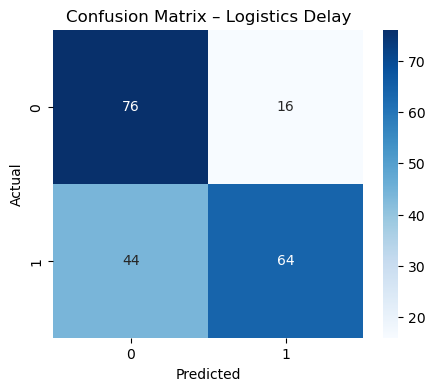

In [69]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistics Delay")
plt.show()

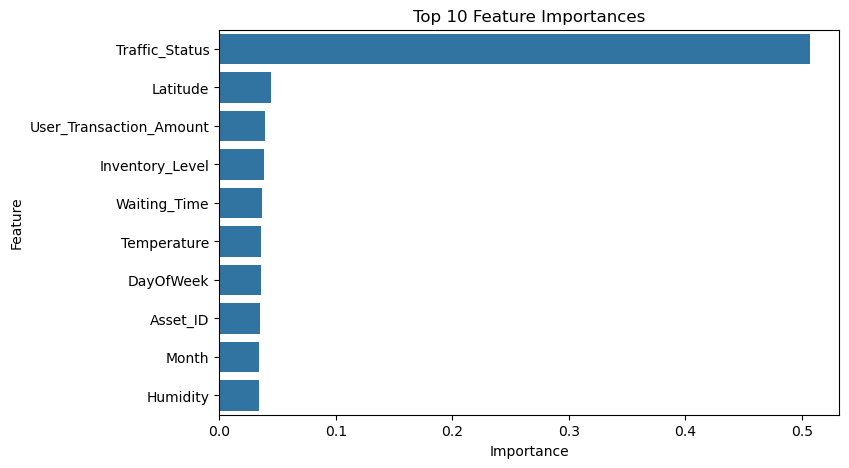

In [70]:
imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(data=imp_df.head(10), x='Importance', y='Feature')
plt.title("Top 10 Feature Importances")
plt.show()

In [71]:
joblib.dump(model, "model_checkpoints/logistics_delay_xgb.pkl")
joblib.dump(encoders, "model_checkpoints/logistics_encoders.pkl")

print("Model and encoders saved.")

Model and encoders saved.


In [72]:
results = {
    "model_name": "XGBoost_Logistics_Delay",
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "test_accuracy": accuracy,
    "roc_auc": roc_auc,
    "train_size": int(len(X_train)),
    "test_size": int(len(X_test)),
    "num_features": len(features),
    "top_features": imp_df.head(10).to_dict(orient="records"),
    "model_parameters": model.get_params()
}

with open("reports/logistics_delay_results.json", "w") as f:
    json.dump(results, f, indent=4)

print("Results saved to logistics_delay_results.json")

Results saved to logistics_delay_results.json


In [73]:
loaded_model = joblib.load("model_checkpoints/logistics_delay_xgb.pkl")
loaded_encoders = joblib.load("model_checkpoints/logistics_encoders.pkl")

loaded_preds = loaded_model.predict(X_test)
print("Loaded model test accuracy:", accuracy_score(y_test, loaded_preds))

Loaded model test accuracy: 0.7
